In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
from os import listdir
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from mlxtend.evaluate import scoring

In [2]:
def importar_dados(arquivo):
    df = pd.read_csv(arquivo, sep=' ', names=['x1', 'x2', 'classe'])
    
    X = df[['x1', 'x2']].values
    y = df['classe'].values
    
    return X, y

In [3]:
def exibir_amostras(X, y, 
                    titulo=None, 
                    salvar=False, 
                    figsize=(10, 8), 
                    legend_fontsize=20, 
                    title_fontsize=24, 
                    labels_fontsize=24, 
                    ticks_fontsize=16):
    
    classes = list(set([classe for classe in y]))
    n_classes = len(classes)
    
    plt.figure(figsize=figsize)
    
    for classe in classes:
        plt.scatter(X[y == classe][:, 0], X[y == classe][:, 1], s=100, label='Classe ' + str(classe))
    
    plt.legend(fontsize=legend_fontsize)
    plt.grid(True, linestyle='-', alpha=0.5)
    
    plt.title(str(titulo), fontsize=title_fontsize)
    plt.xlabel(r'$x_{1}$', fontsize=labels_fontsize)
    plt.ylabel(r'$x_{2}$', fontsize=labels_fontsize)
    plt.xticks(fontsize=ticks_fontsize)
    plt.yticks(fontsize=ticks_fontsize)
    
    if salvar:
        plt.savefig(titulo + '.pdf', format='pdf', dpi=300, transparent=True, bbox_inches='tight')
    
    plt.show()

In [4]:
class AnaliseDiscriminante:
    def __init__ (self, tipo='LDA'):
        self.tipo = tipo
        
    def treinar (self, X, y):
        self.classes = list(set(y))
        self.n_classes = len(self.classes)
        self.n_amostras = len(X)
        self.n_amostras_classe = [len(X[y == c]) for c in self.classes]
        self.probs = [n / self.n_amostras for n in self.n_amostras_classe]
        self.mu = np.mean(X, axis=0)
        self.mu_classe = [np.mean(X[y == c], axis=0) for c in self.classes]
        
        if self.tipo == 'LDA':
            self.sigma = np.cov(X.T)
            self.sigma_inv = np.linalg.inv(self.sigma)
            
        elif self.tipo == 'QDA':
            self.sigma = np.array([np.cov(X[y == c].T) for c in self.classes])
            self.sigma_inv = np.array([np.linalg.inv(matriz) for matriz in self.sigma])
        
        else:
            print("O tipo deve ser 'LDA' ou 'QDA'. Escolha um dos dois!")
        
    def __delta_LDA(self, X, mu, P):
        return (np.matrix(X) * np.matrix(self.sigma_inv).T * np.matrix(mu).T - 0.5 * np.matrix(mu) * np.matrix(self.sigma_inv) * np.matrix(mu).T + np.log(P)).A1[0]
    
    def __delta_QDA(self, X, mu, sigma, sigma_inv, P):
        return (-0.5 * np.log(np.linalg.det(sigma)) - 0.5 * np.matrix(X - mu) * np.matrix(sigma_inv).T * np.matrix(X - mu).T + np.log(P)).A1[0]
        
    def classificar (self, X):
        if self.tipo == 'LDA':
            self.deltas = np.array([[self.__delta_LDA(amostra, self.mu_classe[i], self.probs[i]) for i in range(len(self.classes))] for amostra in X])
        
        elif self.tipo == 'QDA':
            self.deltas = np.array([[self.__delta_QDA(amostra, self.mu_classe[i], self.sigma[i], self.sigma_inv[i], self.probs[i]) for i in range(len(self.classes))] for amostra in X])
        
        else:
            print("O tipo deve ser 'LDA' ou 'QDA'. Escolha um dos dois!")
        
        return np.array([np.argmax(amostra)+1 for amostra in self.deltas])

In [5]:
def holdout(X, y, teste_parcela=0.30, aleatorio=True, semente=None):
    n_amostras = len(X)
    n_amostras_teste = int(teste_parcela * n_amostras)
    n_amostras_treino = n_amostras - n_amostras_teste

    if aleatorio:
        if semente == None:
            semente = random.randint(0, 1000)
        random.seed(semente)
        teste_idx = np.array(sorted(random.sample(range(n_amostras), n_amostras_teste)))

    else:
        teste_idx = np.arange(n_amostras - n_amostras_teste - 1, n_amostras)

    treino_idx = np.array(list(set(np.arange(n_amostras)) - set(teste_idx)))
    X_teste = np.array([X[idx] for idx in teste_idx])
    y_teste = np.array([y[idx] for idx in teste_idx])
    X_treino = np.array([X[idx] for idx in treino_idx])
    y_treino = np.array([y[idx] for idx in treino_idx])
    
    return X_treino, y_treino, X_teste, y_teste

In [6]:
def avaliar_desempenho(y_verdadeiro, y_obtido):
    return scoring(y_verdadeiro, y_obtido, metric='accuracy', )

### Dataset 1

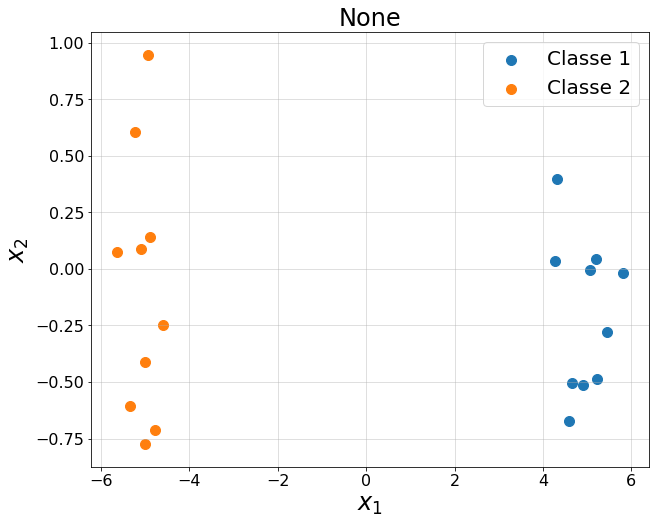

In [7]:
X1, y1 = importar_dados('datasets/dataset1.txt')
exibir_amostras(X=X1, y=y1)

**Classificador mais adequado**: para este caso, o LDA já é suficiente para atuar bem, mas nada impede que seja escolhido o QDA.

In [8]:
# Bootstrap
n_repeticoes = 10

SK_LDA_desempenho = []
ME_LDA_desempenho = []
SK_QDA_desempenho = []
ME_QDA_desempenho = []
for execucao in range(n_repeticoes):
    
    # Holdout
    X_treino, y_treino, X_teste, y_teste = holdout(X=X1, y=y1, teste_parcela=0.30, aleatorio=True, semente=None)

    # LDA - Scikit-Learn
    SK_LDA = LinearDiscriminantAnalysis().fit(X=X_treino, y=y_treino)
    SK_LDA_y_predito = SK_LDA.predict(X=X_teste)
    SK_LDA_desempenho.append(avaliar_desempenho(y_verdadeiro=y_teste, y_obtido=SK_LDA_y_predito))
    
    # LDA - Próprio
    ME_LDA = AnaliseDiscriminante(tipo='LDA')
    ME_LDA.treinar(X=X_treino, y=y_treino)
    ME_LDA_y_predito = ME_LDA.classificar(X=X_teste)
    ME_LDA_desempenho.append(avaliar_desempenho(y_verdadeiro=y_teste, y_obtido=ME_LDA_y_predito))
    
    # QDA - Scikit-Learn
    SK_QDA = QuadraticDiscriminantAnalysis().fit(X=X_treino, y=y_treino)
    SK_QDA_y_predito = SK_QDA.predict(X=X_teste)
    SK_QDA_desempenho.append(avaliar_desempenho(y_verdadeiro=y_teste, y_obtido=SK_QDA_y_predito))
    
    # QDA - Próprio
    ME_QDA = AnaliseDiscriminante(tipo='QDA')
    ME_QDA.treinar(X=X_treino, y=y_treino)
    ME_QDA_y_predito = ME_QDA.classificar(X=X_teste)
    ME_QDA_desempenho.append(avaliar_desempenho(y_verdadeiro=y_teste, y_obtido=ME_QDA_y_predito))

SK_LDA_desempenho = np.array(SK_LDA_desempenho)
SK_LDA_desempenho_media = np.mean(SK_LDA_desempenho)
SK_LDA_desempenho_std = np.std(SK_LDA_desempenho)

ME_LDA_desempenho = np.array(ME_LDA_desempenho)
ME_LDA_desempenho_media = np.mean(ME_LDA_desempenho)
ME_LDA_desempenho_std = np.std(ME_LDA_desempenho)

SK_QDA_desempenho = np.array(SK_QDA_desempenho)
SK_QDA_desempenho_media = np.mean(SK_QDA_desempenho)
SK_QDA_desempenho_std = np.std(SK_QDA_desempenho)

ME_QDA_desempenho = np.array(ME_QDA_desempenho)
ME_QDA_desempenho_media = np.mean(ME_QDA_desempenho)
ME_QDA_desempenho_std = np.std(ME_QDA_desempenho)


print('DATASET 1')
print('------ Acurácias -----')
print('LDA - Scikit: \t{0:3.4f}'.format(SK_LDA_desempenho_media))
print('LDA - Próprio: \t{0:3.4f}'.format(ME_LDA_desempenho_media))
print('----------------------')
print('QDA - Scikit: \t{0:3.4f}'.format(SK_QDA_desempenho_media))
print('QDA - Próprio: \t{0:3.4f}'.format(ME_QDA_desempenho_media))

DATASET 1
------ Acurácias -----
LDA - Scikit: 	1.0000
LDA - Próprio: 	1.0000
----------------------
QDA - Scikit: 	1.0000
QDA - Próprio: 	1.0000


### Dataset 2

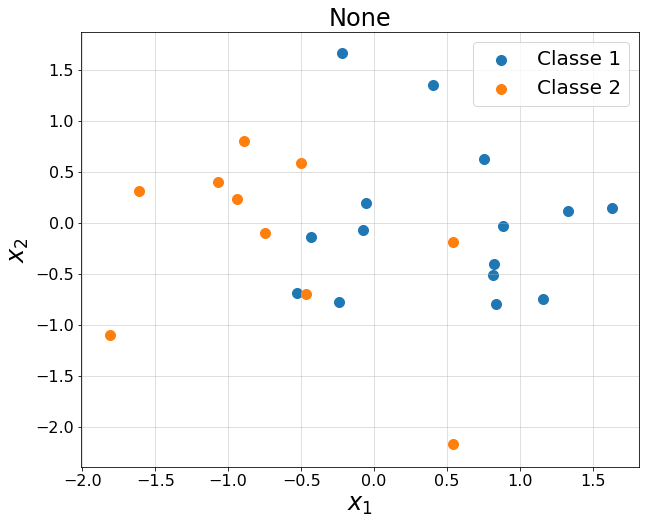

In [9]:
X2, y2 = importar_dados('datasets/dataset2.txt')
exibir_amostras(X=X2, y=y2)

**Classificador mais adequado**: aqui não parece ser possível zerar a taxa de erros, mas é possível observar que o LDA satisfaz a classificação com uma taxa de erros relativamebte baixa.

In [10]:
# Bootstrap
n_repeticoes = 10

SK_LDA_desempenho = []
ME_LDA_desempenho = []
SK_QDA_desempenho = []
ME_QDA_desempenho = []
for execucao in range(n_repeticoes):
    
    # Holdout
    X_treino, y_treino, X_teste, y_teste = holdout(X=X2, y=y2, teste_parcela=0.30, aleatorio=True, semente=None)

    # LDA - Scikit-Learn
    SK_LDA = LinearDiscriminantAnalysis().fit(X=X_treino, y=y_treino)
    SK_LDA_y_predito = SK_LDA.predict(X=X_teste)
    SK_LDA_desempenho.append(avaliar_desempenho(y_verdadeiro=y_teste, y_obtido=SK_LDA_y_predito))
    
    # LDA - Próprio
    ME_LDA = AnaliseDiscriminante(tipo='LDA')
    ME_LDA.treinar(X=X_treino, y=y_treino)
    ME_LDA_y_predito = ME_LDA.classificar(X=X_teste)
    ME_LDA_desempenho.append(avaliar_desempenho(y_verdadeiro=y_teste, y_obtido=ME_LDA_y_predito))
    
    # QDA - Scikit-Learn
    SK_QDA = QuadraticDiscriminantAnalysis().fit(X=X_treino, y=y_treino)
    SK_QDA_y_predito = SK_QDA.predict(X=X_teste)
    SK_QDA_desempenho.append(avaliar_desempenho(y_verdadeiro=y_teste, y_obtido=SK_QDA_y_predito))
    
    # QDA - Próprio
    ME_QDA = AnaliseDiscriminante(tipo='QDA')
    ME_QDA.treinar(X=X_treino, y=y_treino)
    ME_QDA_y_predito = ME_QDA.classificar(X=X_teste)
    ME_QDA_desempenho.append(avaliar_desempenho(y_verdadeiro=y_teste, y_obtido=ME_QDA_y_predito))

SK_LDA_desempenho = np.array(SK_LDA_desempenho)
SK_LDA_desempenho_media = np.mean(SK_LDA_desempenho)
SK_LDA_desempenho_std = np.std(SK_LDA_desempenho)

ME_LDA_desempenho = np.array(ME_LDA_desempenho)
ME_LDA_desempenho_media = np.mean(ME_LDA_desempenho)
ME_LDA_desempenho_std = np.std(ME_LDA_desempenho)

SK_QDA_desempenho = np.array(SK_QDA_desempenho)
SK_QDA_desempenho_media = np.mean(SK_QDA_desempenho)
SK_QDA_desempenho_std = np.std(SK_QDA_desempenho)

ME_QDA_desempenho = np.array(ME_QDA_desempenho)
ME_QDA_desempenho_media = np.mean(ME_QDA_desempenho)
ME_QDA_desempenho_std = np.std(ME_QDA_desempenho)

print('DATASET 2')
print('------ Acurácias -----')
print('LDA - Scikit: \t{0:3.4f}'.format(SK_LDA_desempenho_media))
print('LDA - Próprio: \t{0:3.4f}'.format(ME_LDA_desempenho_media))
print('----------------------')
print('QDA - Scikit: \t{0:3.4f}'.format(SK_QDA_desempenho_media))
print('QDA - Próprio: \t{0:3.4f}'.format(ME_QDA_desempenho_media))

DATASET 2
------ Acurácias -----
LDA - Scikit: 	0.7714
LDA - Próprio: 	0.7429
----------------------
QDA - Scikit: 	0.7571
QDA - Próprio: 	0.7571


### Dataset 3

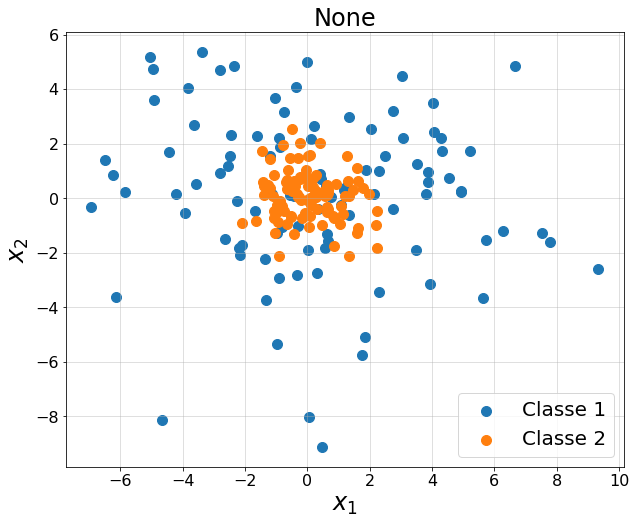

In [11]:
X3, y3 = importar_dados('datasets/dataset3.txt')
exibir_amostras(X=X3, y=y3)

**Classificador mais adequado**: neste dataset é bastante evidente que há uma intensa sobreposição entre os dados, e o QDA é bem mais conveniente.

In [12]:
# Bootstrap
n_repeticoes = 10

SK_LDA_desempenho = []
ME_LDA_desempenho = []
SK_QDA_desempenho = []
ME_QDA_desempenho = []
for execucao in range(n_repeticoes):
    
    # Holdout
    X_treino, y_treino, X_teste, y_teste = holdout(X=X3, y=y3, teste_parcela=0.30, aleatorio=True, semente=None)

    # LDA - Scikit-Learn
    SK_LDA = LinearDiscriminantAnalysis().fit(X=X_treino, y=y_treino)
    SK_LDA_y_predito = SK_LDA.predict(X=X_teste)
    SK_LDA_desempenho.append(avaliar_desempenho(y_verdadeiro=y_teste, y_obtido=SK_LDA_y_predito))
    
    # LDA - Próprio
    ME_LDA = AnaliseDiscriminante(tipo='LDA')
    ME_LDA.treinar(X=X_treino, y=y_treino)
    ME_LDA_y_predito = ME_LDA.classificar(X=X_teste)
    ME_LDA_desempenho.append(avaliar_desempenho(y_verdadeiro=y_teste, y_obtido=ME_LDA_y_predito))
    
    # QDA - Scikit-Learn
    SK_QDA = QuadraticDiscriminantAnalysis().fit(X=X_treino, y=y_treino)
    SK_QDA_y_predito = SK_QDA.predict(X=X_teste)
    SK_QDA_desempenho.append(avaliar_desempenho(y_verdadeiro=y_teste, y_obtido=SK_QDA_y_predito))
    
    # QDA - Próprio
    ME_QDA = AnaliseDiscriminante(tipo='QDA')
    ME_QDA.treinar(X=X_treino, y=y_treino)
    ME_QDA_y_predito = ME_QDA.classificar(X=X_teste)
    ME_QDA_desempenho.append(avaliar_desempenho(y_verdadeiro=y_teste, y_obtido=ME_QDA_y_predito))

SK_LDA_desempenho = np.array(SK_LDA_desempenho)
SK_LDA_desempenho_media = np.mean(SK_LDA_desempenho)
SK_LDA_desempenho_std = np.std(SK_LDA_desempenho)

ME_LDA_desempenho = np.array(ME_LDA_desempenho)
ME_LDA_desempenho_media = np.mean(ME_LDA_desempenho)
ME_LDA_desempenho_std = np.std(ME_LDA_desempenho)

SK_QDA_desempenho = np.array(SK_QDA_desempenho)
SK_QDA_desempenho_media = np.mean(SK_QDA_desempenho)
SK_QDA_desempenho_std = np.std(SK_QDA_desempenho)

ME_QDA_desempenho = np.array(ME_QDA_desempenho)
ME_QDA_desempenho_media = np.mean(ME_QDA_desempenho)
ME_QDA_desempenho_std = np.std(ME_QDA_desempenho)

print('DATASET 3')
print('------ Acurácias -----')
print('LDA - Scikit: \t{0:3.4f}'.format(SK_LDA_desempenho_media))
print('LDA - Próprio: \t{0:3.4f}'.format(ME_LDA_desempenho_media))
print('----------------------')
print('QDA - Scikit: \t{0:3.4f}'.format(SK_QDA_desempenho_media))
print('QDA - Próprio: \t{0:3.4f}'.format(ME_QDA_desempenho_media))

DATASET 3
------ Acurácias -----
LDA - Scikit: 	0.4450
LDA - Próprio: 	0.4450
----------------------
QDA - Scikit: 	0.8033
QDA - Próprio: 	0.8033


### Dataset 4

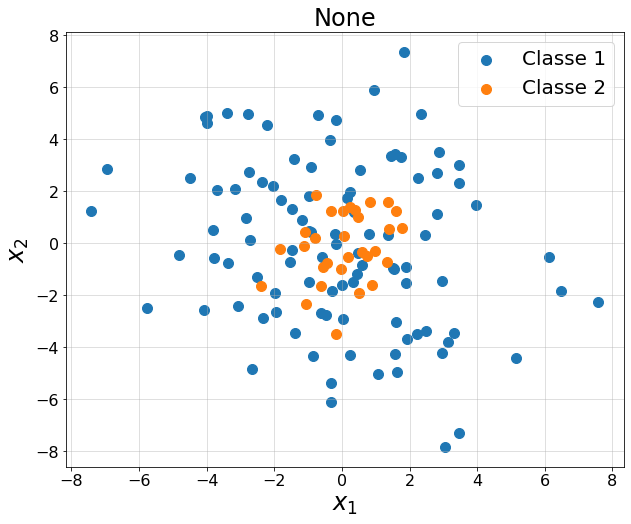

In [13]:
X4, y4 = importar_dados('datasets/dataset4.txt')
exibir_amostras(X=X4, y=y4)

**Classificador mais adequado**: aqui também á uma considerável sobreposição das amostras, mas é menos agressiva do que o observado no dataset anterior. Embora não aparente, LDA e QDA exibirão resultados bastante próximos.

In [14]:
# Bootstrap
n_repeticoes = 10

SK_LDA_desempenho = []
ME_LDA_desempenho = []
SK_QDA_desempenho = []
ME_QDA_desempenho = []
for execucao in range(n_repeticoes):
    
    # Holdout
    X_treino, y_treino, X_teste, y_teste = holdout(X=X4, y=y4, teste_parcela=0.30, aleatorio=True, semente=None)

    # LDA - Scikit-Learn
    SK_LDA = LinearDiscriminantAnalysis().fit(X=X_treino, y=y_treino)
    SK_LDA_y_predito = SK_LDA.predict(X=X_teste)
    SK_LDA_desempenho.append(avaliar_desempenho(y_verdadeiro=y_teste, y_obtido=SK_LDA_y_predito))
    
    # LDA - Próprio
    ME_LDA = AnaliseDiscriminante(tipo='LDA')
    ME_LDA.treinar(X=X_treino, y=y_treino)
    ME_LDA_y_predito = ME_LDA.classificar(X=X_teste)
    ME_LDA_desempenho.append(avaliar_desempenho(y_verdadeiro=y_teste, y_obtido=ME_LDA_y_predito))
    
    # QDA - Scikit-Learn
    SK_QDA = QuadraticDiscriminantAnalysis().fit(X=X_treino, y=y_treino)
    SK_QDA_y_predito = SK_QDA.predict(X=X_teste)
    SK_QDA_desempenho.append(avaliar_desempenho(y_verdadeiro=y_teste, y_obtido=SK_QDA_y_predito))
    
    # QDA - Próprio
    ME_QDA = AnaliseDiscriminante(tipo='QDA')
    ME_QDA.treinar(X=X_treino, y=y_treino)
    ME_QDA_y_predito = ME_QDA.classificar(X=X_teste)
    ME_QDA_desempenho.append(avaliar_desempenho(y_verdadeiro=y_teste, y_obtido=ME_QDA_y_predito))

SK_LDA_desempenho = np.array(SK_LDA_desempenho)
SK_LDA_desempenho_media = np.mean(SK_LDA_desempenho)
SK_LDA_desempenho_std = np.std(SK_LDA_desempenho)

ME_LDA_desempenho = np.array(ME_LDA_desempenho)
ME_LDA_desempenho_media = np.mean(ME_LDA_desempenho)
ME_LDA_desempenho_std = np.std(ME_LDA_desempenho)

SK_QDA_desempenho = np.array(SK_QDA_desempenho)
SK_QDA_desempenho_media = np.mean(SK_QDA_desempenho)
SK_QDA_desempenho_std = np.std(SK_QDA_desempenho)

ME_QDA_desempenho = np.array(ME_QDA_desempenho)
ME_QDA_desempenho_media = np.mean(ME_QDA_desempenho)
ME_QDA_desempenho_std = np.std(ME_QDA_desempenho)

print('DATASET 4')
print('------ Acurácias -----')
print('LDA - Scikit: \t{0:3.4f}'.format(SK_LDA_desempenho_media))
print('LDA - Próprio: \t{0:3.4f}'.format(ME_LDA_desempenho_media))
print('----------------------')
print('QDA - Scikit: \t{0:3.4f}'.format(SK_QDA_desempenho_media))
print('QDA - Próprio: \t{0:3.4f}'.format(ME_QDA_desempenho_media))

DATASET 4
------ Acurácias -----
LDA - Scikit: 	0.7872
LDA - Próprio: 	0.7872
----------------------
QDA - Scikit: 	0.7564
QDA - Próprio: 	0.7564


### Dataset 5

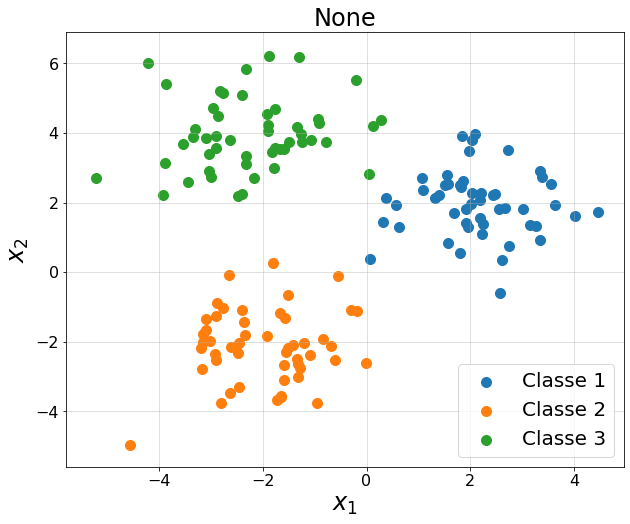

In [15]:
X5, y5 = importar_dados('datasets/dataset5.txt')
exibir_amostras(X=X5, y=y5)

**Classificador mais adequado**: este é um caso em que não há qualquer sobreposição. Embora não seja fácil, é possível realizar uma classificação perfeita, com zero erros, utilizando um classificador linear, portanto, o LDA já é suficiente para satisfazer o problema, mas nada impede que o QDA seja utilizado.

In [16]:
# Bootstrap
n_repeticoes = 10

SK_LDA_desempenho = []
ME_LDA_desempenho = []
SK_QDA_desempenho = []
ME_QDA_desempenho = []
for execucao in range(n_repeticoes):
    
    # Holdout
    X_treino, y_treino, X_teste, y_teste = holdout(X=X5, y=y5, teste_parcela=0.30, aleatorio=True, semente=None)

    # LDA - Scikit-Learn
    SK_LDA = LinearDiscriminantAnalysis().fit(X=X_treino, y=y_treino)
    SK_LDA_y_predito = SK_LDA.predict(X=X_teste)
    SK_LDA_desempenho.append(avaliar_desempenho(y_verdadeiro=y_teste, y_obtido=SK_LDA_y_predito))
    
    # LDA - Próprio
    ME_LDA = AnaliseDiscriminante(tipo='LDA')
    ME_LDA.treinar(X=X_treino, y=y_treino)
    ME_LDA_y_predito = ME_LDA.classificar(X=X_teste)
    ME_LDA_desempenho.append(avaliar_desempenho(y_verdadeiro=y_teste, y_obtido=ME_LDA_y_predito))
    
    # QDA - Scikit-Learn
    SK_QDA = QuadraticDiscriminantAnalysis().fit(X=X_treino, y=y_treino)
    SK_QDA_y_predito = SK_QDA.predict(X=X_teste)
    SK_QDA_desempenho.append(avaliar_desempenho(y_verdadeiro=y_teste, y_obtido=SK_QDA_y_predito))
    
    # QDA - Próprio
    ME_QDA = AnaliseDiscriminante(tipo='QDA')
    ME_QDA.treinar(X=X_treino, y=y_treino)
    ME_QDA_y_predito = ME_QDA.classificar(X=X_teste)
    ME_QDA_desempenho.append(avaliar_desempenho(y_verdadeiro=y_teste, y_obtido=ME_QDA_y_predito))

SK_LDA_desempenho = np.array(SK_LDA_desempenho)
SK_LDA_desempenho_media = np.mean(SK_LDA_desempenho)
SK_LDA_desempenho_std = np.std(SK_LDA_desempenho)

ME_LDA_desempenho = np.array(ME_LDA_desempenho)
ME_LDA_desempenho_media = np.mean(ME_LDA_desempenho)
ME_LDA_desempenho_std = np.std(ME_LDA_desempenho)

SK_QDA_desempenho = np.array(SK_QDA_desempenho)
SK_QDA_desempenho_media = np.mean(SK_QDA_desempenho)
SK_QDA_desempenho_std = np.std(SK_QDA_desempenho)

ME_QDA_desempenho = np.array(ME_QDA_desempenho)
ME_QDA_desempenho_media = np.mean(ME_QDA_desempenho)
ME_QDA_desempenho_std = np.std(ME_QDA_desempenho)

print('DATASET 5')
print('------ Acurácias -----')
print('LDA - Scikit: \t{0:3.4f}'.format(SK_LDA_desempenho_media))
print('LDA - Próprio: \t{0:3.4f}'.format(ME_LDA_desempenho_media))
print('----------------------')
print('QDA - Scikit: \t{0:3.4f}'.format(SK_QDA_desempenho_media))
print('QDA - Próprio: \t{0:3.4f}'.format(ME_QDA_desempenho_media))

DATASET 5
------ Acurácias -----
LDA - Scikit: 	0.9889
LDA - Próprio: 	0.9800
----------------------
QDA - Scikit: 	0.9844
QDA - Próprio: 	0.9844


### Dataset 6

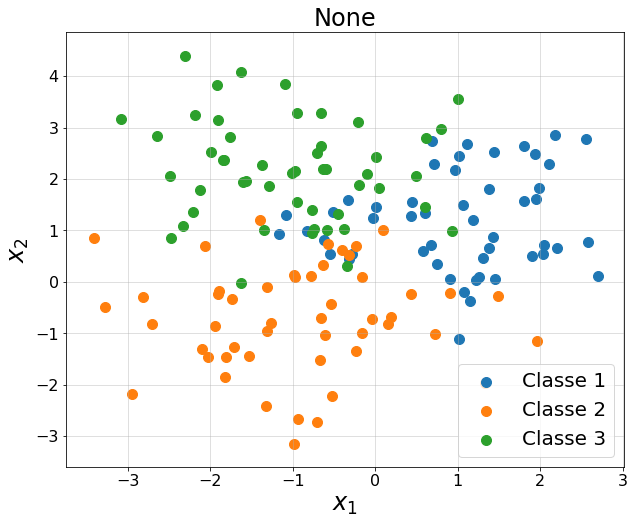

In [17]:
X6, y6 = importar_dados('datasets/dataset6.txt')
exibir_amostras(X=X6, y=y6)

**Classificador mais adequado**: neste caso já há sobreposição, o que não permite uma classificação completamente isenta de erros, mas um bom desempenho pode ser alcançado por ambos os classificadores, sem que haja grandes diferenças entre eles.

In [18]:
# Bootstrap
n_repeticoes = 10

SK_LDA_desempenho = []
ME_LDA_desempenho = []
SK_QDA_desempenho = []
ME_QDA_desempenho = []
for execucao in range(n_repeticoes):
    
    # Holdout
    X_treino, y_treino, X_teste, y_teste = holdout(X=X6, y=y6, teste_parcela=0.30, aleatorio=True, semente=None)

    # LDA - Scikit-Learn
    SK_LDA = LinearDiscriminantAnalysis().fit(X=X_treino, y=y_treino)
    SK_LDA_y_predito = SK_LDA.predict(X=X_teste)
    SK_LDA_desempenho.append(avaliar_desempenho(y_verdadeiro=y_teste, y_obtido=SK_LDA_y_predito))
    
    # LDA - Próprio
    ME_LDA = AnaliseDiscriminante(tipo='LDA')
    ME_LDA.treinar(X=X_treino, y=y_treino)
    ME_LDA_y_predito = ME_LDA.classificar(X=X_teste)
    ME_LDA_desempenho.append(avaliar_desempenho(y_verdadeiro=y_teste, y_obtido=ME_LDA_y_predito))
    
    # QDA - Scikit-Learn
    SK_QDA = QuadraticDiscriminantAnalysis().fit(X=X_treino, y=y_treino)
    SK_QDA_y_predito = SK_QDA.predict(X=X_teste)
    SK_QDA_desempenho.append(avaliar_desempenho(y_verdadeiro=y_teste, y_obtido=SK_QDA_y_predito))
    
    # QDA - Próprio
    ME_QDA = AnaliseDiscriminante(tipo='QDA')
    ME_QDA.treinar(X=X_treino, y=y_treino)
    ME_QDA_y_predito = ME_QDA.classificar(X=X_teste)
    ME_QDA_desempenho.append(avaliar_desempenho(y_verdadeiro=y_teste, y_obtido=ME_QDA_y_predito))

SK_LDA_desempenho = np.array(SK_LDA_desempenho)
SK_LDA_desempenho_media = np.mean(SK_LDA_desempenho)
SK_LDA_desempenho_std = np.std(SK_LDA_desempenho)

ME_LDA_desempenho = np.array(ME_LDA_desempenho)
ME_LDA_desempenho_media = np.mean(ME_LDA_desempenho)
ME_LDA_desempenho_std = np.std(ME_LDA_desempenho)

SK_QDA_desempenho = np.array(SK_QDA_desempenho)
SK_QDA_desempenho_media = np.mean(SK_QDA_desempenho)
SK_QDA_desempenho_std = np.std(SK_QDA_desempenho)

ME_QDA_desempenho = np.array(ME_QDA_desempenho)
ME_QDA_desempenho_media = np.mean(ME_QDA_desempenho)
ME_QDA_desempenho_std = np.std(ME_QDA_desempenho)

print('DATASET 6')
print('------ Acurácias -----')
print('LDA - Scikit: \t{0:3.4f}'.format(SK_LDA_desempenho_media))
print('LDA - Próprio: \t{0:3.4f}'.format(ME_LDA_desempenho_media))
print('----------------------')
print('QDA - Scikit: \t{0:3.4f}'.format(SK_QDA_desempenho_media))
print('QDA - Próprio: \t{0:3.4f}'.format(ME_QDA_desempenho_media))

DATASET 6
------ Acurácias -----
LDA - Scikit: 	0.8222
LDA - Próprio: 	0.8089
----------------------
QDA - Scikit: 	0.8156
QDA - Próprio: 	0.8156
